# Оценка риска ДТП

Необходимо создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. 

Под риском понимается вероятность ДТП с любым повреждением транспортного средства. 

Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. 

Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

**Цель:**
- создать модель предсказания ДТП
- определить основные факторы ДТП
- сформировать задачи для коллег (решить их самому, для примера)
- оценить возможно ли создать адекватную систему оценки риска
- предложить варианты контроля/штрафов

**Метрика:**
- метрика для оценки качества модели ROC AUC

**Точность:**
- Необходимая точность метрики в данной задаче не установлена

Для работы предоставили базу данных по проишествиям:

**Красткое описание таблиц**
- **`collisions`** — общая информация о ДТП
Имеет уникальный `case_id`. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

- **`parties`** — информация об участниках ДТП
Имеет неуникальный `case_id`, который сопоставляется с соответствующим ДТП в таблице `collisions`. 

    Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением `case_id`. 

    Если нужен уникальный идентификатор, это `case_id` and `party_number`.

- **`vehicles`** — информация о пострадавших машинах
Имеет неуникальные `case_id` и неуникальные `party_number`, которые сопоставляются с таблицей `collisions` и таблицей `parties`. 

    Если нужен уникальный идентификатор, это `case_id` and `party_number`.

## Подключение к базе. Загрузка таблицы из sql

#### Библиотеки

In [1]:
# !pip install catboost
# !pip install skimpy

In [2]:
import pandas as pd
import numpy as np

from skimpy import skim

from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay

import time

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
RANDOM = 12345
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from db_config import db_config

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [7]:
engine = create_engine(connection_string)

In [8]:
case_ids_query = '''SELECT * FROM case_ids'''
vehicles_query = '''SELECT * FROM vehicles'''
collisions_query = '''SELECT * FROM collisions'''
parties_query = '''SELECT * FROM parties'''

In [9]:
collisions_df = pd.read_sql_query(collisions_query, con=engine, parse_dates='collision_date')

In [10]:
#case_ids_df = pd.read_sql_query(case_ids_query, con=engine)

In [11]:
parties_df = pd.read_sql_query(parties_query, con=engine)

In [12]:
vehicles_df = pd.read_sql_query(vehicles_query, con=engine)

**Данные загружены**



Общий ключ есть - `case_id`



## Первичное исследование таблиц

In [13]:
skim(vehicles_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 1021234 │ │ string      │ 3     │                                                         │
│ │ Number of columns │ 6       │ │ int64       │ 2     │                                                         │
│ └───────────────────┴─────────┘ │ float64     │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA      ┃ NA %   ┃ mean     ┃ sd       ┃ p0  ┃ p25      ┃ p75       ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ id               │       0 │      0 │   760000 │   440000 │   1 │   380000 │   1100000 │  1500000 │ ██████ │  │
│ │ party_number     │       0 │      0 │      1.6 │     0.68 │   1 │        1 │         2 │       27 │   █    │  │
│ │ vehicle_age      │   25000 │    2.4 │      5.1 │      3.1 │   0 │        3 │         7 │      160 │   █    │  │
│ └──────────────────┴─────────┴────────┴──────────┴──────────┴─────┴──────────┴───────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA         ┃ NA %     ┃ words per row           ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ case_id                             │          0 │        0 │                       1 │            1000000 │  │
│ │ vehicle_type                        │          0 │        0 │                       1 │            1000000 │  │
│ │ vehicle_transmission                │      24000 │      2.3 │                       1 │            1000000 │  │
│ └─────────────────────────────────────┴────────────┴──────────┴─────────────────────────┴────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [14]:
skim(collisions_df[['case_id', 'county_city_location', 'county_location', 'distance',
       'direction', 'intersection', 'weather_1', 'location_type',
       'collision_damage', 'party_count', 'primary_collision_factor',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'road_surface', 'road_condition_1',
       'lighting', 'control_device', 'collision_date']])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 1400000 │ │ string      │ 15    │                                                         │
│ │ Number of columns │ 19      │ │ float64     │ 2     │                                                         │
│ └───────────────────┴─────────┘ │ int64       │ 1     │                                                         │
│                                 │ datetime64  │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA       ┃ NA %    ┃ mean    ┃ sd       ┃ p0   ┃ p25   ┃ p75   ┃ p100       ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩  │
│ │ distance           │        0 │       0 │     660 │    12000 │    0 │     2 │   430 │    8400000 │    █    │  │
│ │ intersection       │    12000 │    0.87 │    0.22 │     0.42 │    0 │     0 │     0 │          1 │ █    ▂  │  │
│ │ party_count        │        0 │       0 │       2 │     0.67 │    1 │     2 │     2 │         27 │    █    │  │
│ └────────────────────┴──────────┴─────────┴─────────┴──────────┴──────┴───────┴───────┴────────────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA    ┃ NA %     ┃ first              ┃ last               ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ collision_date             │     0 │        0 │     2009-01-01     │     2020-07-26     │ None             │  │
│ └────────────────────────────┴───────┴──────────┴────────────────────┴────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ NA          ┃ NA %     ┃ words per row           ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ case_id                            │           0 │        0 │                       1 │            1400000 │  │
│ │ county_city_location               │           0 │        0 │                       1 │            1400000 │  │
│ │ county_location                    │           0 │        0 │                       1 │            1400000 │  │
│ │ direction                          │      340000 │       24 │                       1 │            1400000 │  │
│ │ weather_1                          │        7300 │     0.52 │                       1 │            1400000 │  │
│ │ location_type                      │      880000 │       63 │                       1 │            1400000 │  │
│ │ collision_damage                   │           0 │  

In [15]:
skim(parties_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 2752408 │ │ string      │ 4     │                                                         │
│ │ Number of columns │ 9       │ │ int64       │ 3     │                                                         │
│ └───────────────────┴─────────┘ │ float64     │ 2     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name          ┃ NA      ┃ NA %  ┃ mean     ┃ sd      ┃ p0  ┃ p25     ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ id                   │       0 │     0 │  1400000 │  790000 │   1 │  690000 │  2100000 │  2800000 │ ██████ │  │
│ │ party_number         │       0 │     0 │      1.6 │    0.72 │   1 │       1 │        2 │       27 │   █    │  │
│ │ at_fault             │       0 │     0 │     0.47 │     0.5 │   0 │       0 │        1 │        1 │ █    ▇ │  │
│ │ insurance_premium    │  410000 │    15 │       39 │      16 │   0 │      25 │       50 │      100 │ ▁█▆▃▁  │  │
│ │ cellphone_in_use     │  510000 │    19 │     0.02 │    0.14 │   0 │       0 │        0 │        1 │   █    │  │
│ └──────────────────────┴─────────┴───────┴──────────┴─────────┴─────┴─────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA            ┃ NA %     ┃ words per row          ┃ total words        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩  │
│ │ case_id                           │             0 │        0 │                      1 │            2800000 │  │
│ │ party_type                        │          3600 │     0.13 │                      1 │            2800000 │  │
│ │ party_sobriety                    │         74000 │      2.7 │                      1 │            2800000 │  │
│ │ party_drug_physical               │       2300000 │       84 │                      1 │            2800000 │  │
│ └───────────────────────────────────┴───────────────┴──────────┴────────────────────────┴────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [16]:
df_list = [vehicles_df, collisions_df, parties_df]
df_name = ['vehicles_df', 'collisions_df', 'parties_df']

for i in range(len(df_list)):
    print(df_name[i].upper())
    print(df_list[i].info())
    print(df_list[i].shape)
    print('Пропуски')
    print(df_list[i].isnull().sum())
    display(df_list[i].head())
    print()
    print('-------------------------')
    print()

VEHICLES_DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  string 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  string 
 4   vehicle_transmission  997575 non-null   string 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), string(3)
memory usage: 46.7 MB
None
(1021234, 6)
Пропуски
id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0



-------------------------

COLLISIONS_DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   case_id                      1400000 non-null  object        
 1   county_city_location         1400000 non-null  object        
 2   county_location              1400000 non-null  object        
 3   distance                     1400000 non-null  float64       
 4   direction                    1059358 non-null  object        
 5   intersection                 1387781 non-null  float64       
 6   weather_1                    1392741 non-null  object        
 7   location_type                518779 non-null   object        
 8   collision_damage             1400000 non-null  object        
 9   party_count                  1400000 non-null  int64         
 10  primary_collision_factor     1391834

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00



-------------------------

PARTIES_DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              string 
 2   party_number         int64  
 3   party_type           string 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       string 
 7   party_drug_physical  string 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), string(4)
memory usage: 189.0 MB
None
(2752408, 9)
Пропуски
id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,<NA>,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,<NA>,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,<NA>,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,<NA>,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0



-------------------------



**Вывод:**

- Данные есть во всех таблицах
- `case_id` есть во всех таблицах
- в `case_id` нет пропусков, что хорошо для объединения таблиц
- в некоторых таблицах есть пропуски, при дальнейшем анализе оценю необходимость их заполнения
- нам предоставили 1 400 000 случаев дтп для анализа и работы

##  Статистический анализ факторов ДТП

Осмотрим количество проишествий по месяцам

In [17]:
collisions_by_month_query = '''
SELECT DATE_TRUNC('MONTH', collision_date)::date AS date,
        COUNT(*)
FROM collisions
GROUP BY DATE_TRUNC('MONTH', collision_date)::date
'''

coll_by_month = pd.read_sql_query(collisions_by_month_query, con=engine)

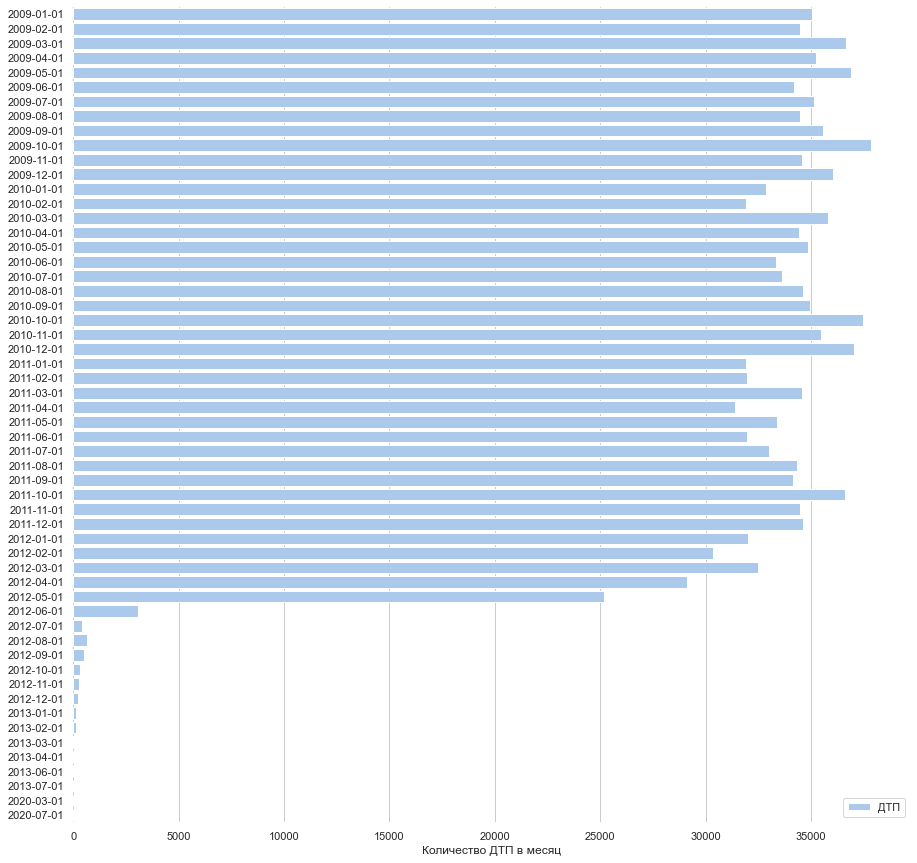

In [18]:
f, ax = plt.subplots(figsize=(15, 15))


sns.set_color_codes("pastel")
sns.barplot(x="count", y="date", data=coll_by_month,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество ДТП в месяц")
sns.despine(left=True, bottom=True)


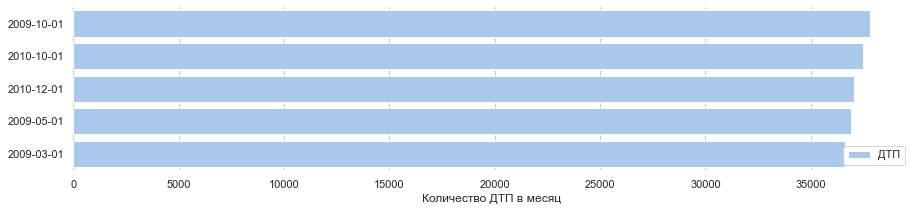

In [19]:
f, ax = plt.subplots(figsize=(15, 3))


sns.set_color_codes("pastel")
sns.barplot(x="count", y="date", data=coll_by_month.sort_values('count', ascending=False)[:5],
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество ДТП в месяц")
sns.despine(left=True, bottom=True)


**Вывод:**

Самые богатые на проишествия месяцы это Октябрь, Декабрь, Май, Март

В Октябре дождливая погода и, вполне может быть, из-за ухудшения видимости увеличивается кол-во ДТП

Декабрь - очевидно, зима, снег, скользко, предновогодняя спешка, преждевременное начало отмечания Нового Года, нервы)

Май и Март - скорее всего, связаны с обилием праздников, а обилие праздников = бурные потоки дачников, пьяны и увереных в себе водителях)

In [20]:
collisions_by_month_query_1 = '''
SELECT EXTRACT(MONTH FROM collision_date) AS month,
        COUNT(*)
FROM collisions
GROUP BY EXTRACT(MONTH FROM collision_date)
'''

coll_by_month_1 = pd.read_sql_query(collisions_by_month_query_1, con=engine)

coll_by_month_1

,month,count
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


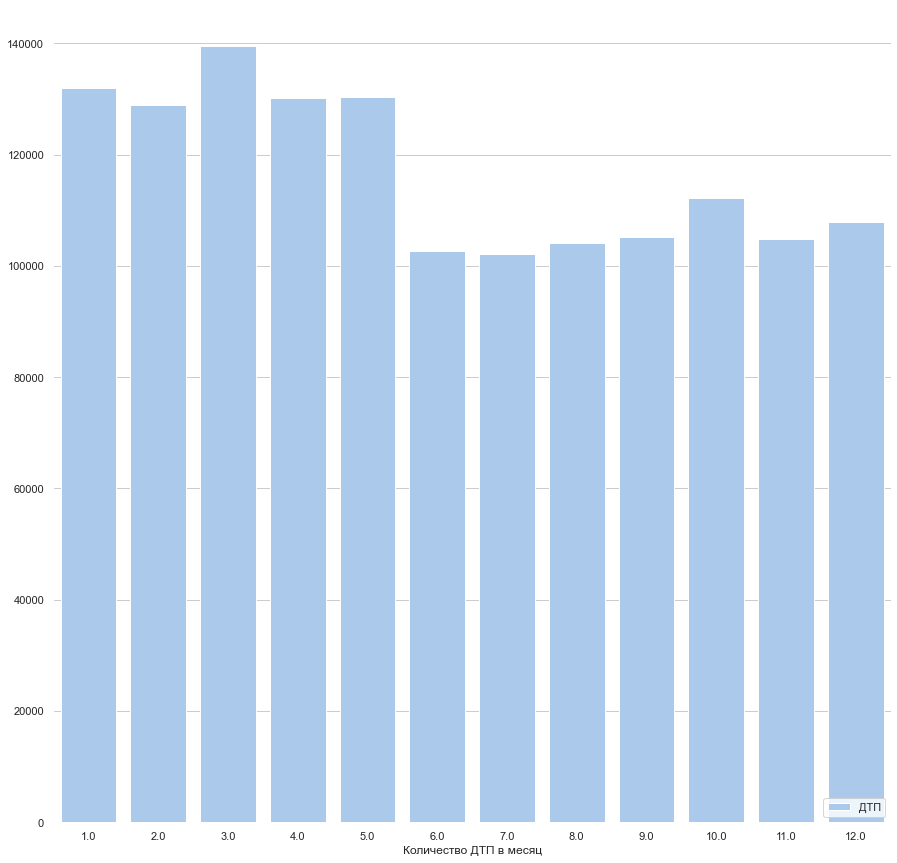

In [21]:
f, ax = plt.subplots(figsize=(15, 15))


sns.set_color_codes("pastel")
sns.barplot(x="month", y="count", data=coll_by_month_1,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество ДТП в месяц")
sns.despine(left=True, bottom=True)

### Задачи для коллег!

Прошу проверить и выяснить:


1. С какой коробкой передач чаще происходят аварии на перекрестке?
    
    **Инструкция к выполнению:**
    * Напишите SQL запрос, объединяющий таблицы `collisions` и `vehicles`
    * Постройте barplot для визуализации результата (или другой удобный график для чтения)
    * Опишите результат


2. В каком районе произошло самое большое количество проишествий с индексом `FATAL ТС`?

3. Куда направлялись водители в состоянии C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием) и в какое время?

4. В какую погоду чаще происходит ДТП у I — Sleepy/Fatigued (Сонный/Усталый) водителя?

    **Инструкция к выполнению:**
    * Напишите SQL запрос, объединяющий таблицы `collisions` и `parties`
    * Постройте barplot для визуализации результата (или другой удобный график для чтения)
    * Опишите результат
    

5. Куда чаще всего врезаются водители под воздействием лекарств?

6. Как сильно влияет возраст автомобиля на процент аварий?



In [22]:
first_task = '''
SELECT v.vehicle_transmission, 
      COUNT(*)
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE c.intersection = 1
AND v.vehicle_transmission != 'not stated'
GROUP BY v.vehicle_transmission
'''

first_t = pd.read_sql_query(first_task, con=engine)

first_t

,vehicle_transmission,count
0,auto,138418
1,manual,126277


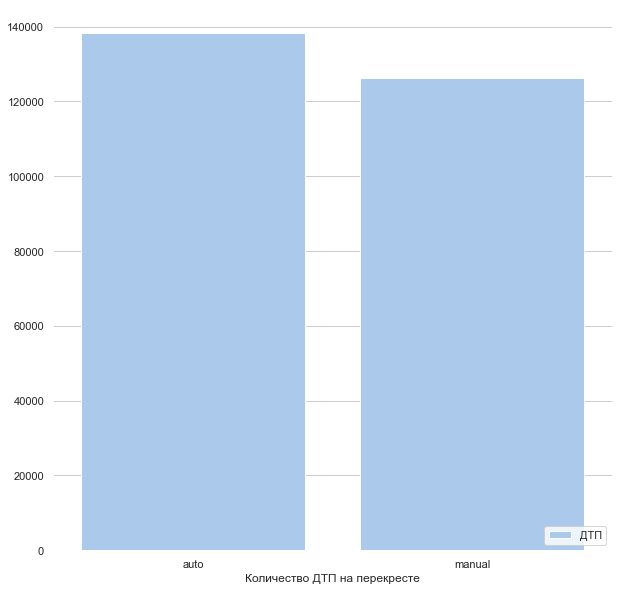

In [23]:
f, ax = plt.subplots(figsize=(10, 10))


sns.set_color_codes("pastel")
sns.barplot(x="vehicle_transmission", y="count", data=first_t,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество ДТП на перекресте")
sns.despine(left=True, bottom=True)

**Вывод**

Видим, что разница совсем не большая, но скорее всего водители с автоматической коробкой более расслаблены и менее опытны в вождении

В какую погоду чаще происходит ДТП у I — Sleepy/Fatigued (Сонный/Усталый) водителя?

In [24]:
second_task = '''
SELECT c.weather_1 AS weather, 
      COUNT(*)
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_drug_physical = 'sleepy/fatigued'
GROUP BY weather
'''

second_t = pd.read_sql_query(second_task, con=engine)

second_t

,weather,count
0,clear,10326
1,cloudy,1908
2,fog,108
3,other,12
4,raining,231
5,snowing,6
6,wind,4
7,None,46


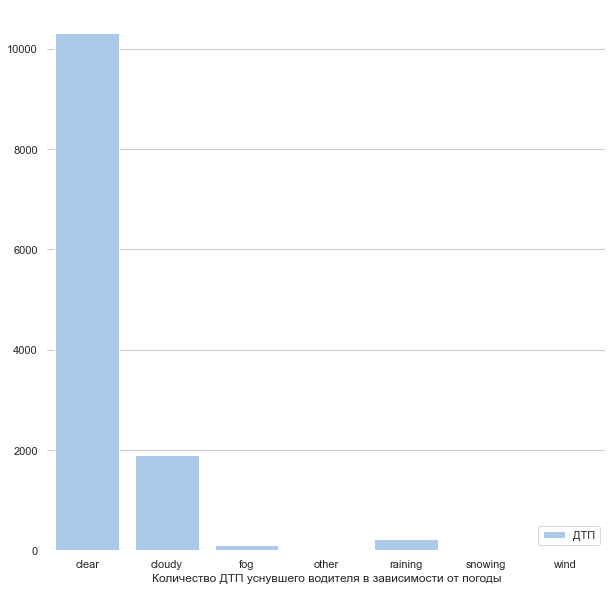

In [25]:
f, ax = plt.subplots(figsize=(10, 10))


sns.set_color_codes("pastel")
sns.barplot(x="weather", y="count", data=second_t,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество ДТП уснувшего водителя в зависимости от погоды")
sns.despine(left=True, bottom=True)

**Вывод**

Удивительно, но погода никак не влияет на то, что уснет водитель за рулем или нет. Хотя и в 4.00 утра может быть ясно, а человек не спал

## Создание модели для оценки водительского риска

### Создание датасета на основе запросов заказчика

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)

Для модели выбрать тип виновника — только машина (car).

Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

Для моделирования ограничиться данными за 2012 год — они самые свежие.

Обязательное условие — учесть фактор возраста автомобиля.

In [26]:
main_querry = '''
SELECT *
FROM parties AS p
JOIN collisions AS c ON p.case_id = c.case_id
JOIN vehicles AS v ON p.case_id = v.case_id
WHERE p.party_type = 'car'
AND c.collision_damage != 'scratch'
AND EXTRACT(YEAR FROM c.collision_date) = 2012
'''

df = pd.read_sql_query(main_querry, con=engine)

df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,...,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2410880,5457190,2,car,0,29.0,had not been drinking,None,0.0,5457190,...,dark with no street lights,none,2012-02-07,04:50:00,1328841,5457190,1,sedan,manual,0.0
1,2414965,5459307,1,car,1,41.0,had not been drinking,None,0.0,5459307,...,daylight,none,2012-01-31,12:40:00,1330859,5459307,1,sedan,auto,5.0
2,2424883,5464780,1,car,1,69.0,had not been drinking,None,0.0,5464780,...,dark with street lights,none,2012-01-12,17:35:00,1336237,5464780,1,sedan,manual,4.0
3,2462386,5484983,3,car,0,NaN,impairment unknown,G,0.0,5484983,...,daylight,functioning,2012-01-27,12:50:00,1356996,5484983,1,sedan,manual,2.0
4,2462386,5484983,3,car,0,NaN,impairment unknown,G,0.0,5484983,...,daylight,functioning,2012-01-27,12:50:00,1356998,5484983,2,sedan,auto,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,2408972,5456210,1,car,0,47.0,had not been drinking,None,0.0,5456210,...,daylight,none,2012-01-11,11:20:00,1327864,5456210,2,sedan,manual,0.0
118407,2408973,5456210,2,car,1,32.0,had not been drinking,None,0.0,5456210,...,daylight,none,2012-01-11,11:20:00,1327862,5456210,1,sedan,auto,3.0
118408,2408973,5456210,2,car,1,32.0,had not been drinking,None,0.0,5456210,...,daylight,none,2012-01-11,11:20:00,1327864,5456210,2,sedan,manual,0.0
118409,2408990,5456219,1,car,1,30.0,had not been drinking,None,0.0,5456219,...,dark with street lights,functioning,2012-01-12,17:30:00,1327869,5456219,2,sedan,auto,0.0


In [27]:
df.party_type.unique()

array(['car'], dtype=object)

In [28]:
df.collision_damage.unique()

array(['small damage', 'middle damage', 'severe damage', 'fatal'],
      dtype=object)

In [29]:
df.collision_date.max()

datetime.date(2012, 12, 31)

In [30]:
df.collision_date.min()

datetime.date(2012, 1, 1)

In [31]:
df.columns

Index(['id', 'case_id', 'party_number', 'party_type', 'at_fault',
       'insurance_premium', 'party_sobriety', 'party_drug_physical',
       'cellphone_in_use', 'case_id', 'county_city_location',
       'county_location', 'distance', 'direction', 'intersection', 'weather_1',
       'location_type', 'collision_damage', 'party_count',
       'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
       'road_condition_1', 'lighting', 'control_device', 'collision_date',
       'collision_time', 'id', 'case_id', 'party_number', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [32]:
columns = [
           'party_sobriety', # Один из основных факторов - трезвость напрямую влияет на способность управления авто, 
                            # ведь так много смелых после пары пив
           #'party_drug_physical', # Довольно полезный фактор, но в данных за 2012 год пропусков 109716 из 111411, а заполнить нам их сейчас нечем
           'cellphone_in_use', # Две руки для управления авто - лучше чем одна свободная и согнутая шея) 
           'county_location', # Районы также влияют на вероятность дтп, ведь где-то идеальный асфальт, светофоры и тд, а где-то
                            # знаки и светофоры закрыты деревьями, разбитые перекрестки, ямы
           'intersection', # Ну перекрестки - кладезь аварий, историй и возможностей)
           'weather_1', # Погода - напрямую влияет. Дождь, туман, снег - видимость никакая, сцепление ухудшилось - привет дтп
           #'location_type', # Не уверен, что важный фактор для модели, но учитывая, что на шоссе повышенная скорость, а перекресток
                            # сам по себе магнит для ДТП предлагаю пока оставить, дальше можно будет оценить важность признака
                            # Но учитывая кол-во пропущеных значений - придется отказаться и брать во внимание только перекресток
           'collision_damage', # Насколько серьезным оказались повреждения. Важный фактор
           'primary_collision_factor', # Столбец, объясняющий причину ДТП. 
           'pcf_violation_category', # Столбец, который объясняет почему случилось ДТП, настолько важный фактор, что без него никуда)
           'road_surface', # Каким было покрытие дороги в момент ДТП, мокрое, обледенелое, а ты на летней резине)
           'road_condition_1', # Вот как раз состояние дороги, которое так же может зависеть от района. Ямы, ремонт и прочее
           'vehicle_type', # Тип авто - не очень важный фактор, но купе или седан обладают большей возможностью для маневров, как и 
                            # послужившими причиной ДТП, так и возможностью эти ДТП избежать. Минивены более громоздкие, длиннее
                            # тормозной путь
           'vehicle_age', # Ну если старичок - то и тормоза отказать могут)

           'at_fault' # Наш целевой признак
]

In [33]:
df = df[columns].copy()

In [34]:
df.isnull().sum()

party_sobriety               1729
cellphone_in_use            10904
county_location                 0
intersection                  368
weather_1                     389
collision_damage                0
primary_collision_factor      264
pcf_violation_category       1725
road_surface                  766
road_condition_1              568
vehicle_type                    0
vehicle_age                  3365
at_fault                        0
dtype: int64

In [35]:
df

,party_sobriety,cellphone_in_use,county_location,intersection,weather_1,collision_damage,primary_collision_factor,pcf_violation_category,road_surface,road_condition_1,vehicle_type,vehicle_age,at_fault
0,had not been drinking,0.0,los angeles,0.0,cloudy,small damage,vehicle code violation,improper turning,dry,normal,sedan,0.0,0
1,had not been drinking,0.0,fresno,0.0,clear,small damage,vehicle code violation,improper turning,dry,normal,sedan,5.0,1
2,had not been drinking,0.0,riverside,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,4.0,1
3,impairment unknown,0.0,shasta,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,2.0,0
4,impairment unknown,0.0,shasta,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,0.0,0
118407,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,3.0,1
118408,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,0.0,1
118409,had not been drinking,0.0,los angeles,0.0,clear,small damage,vehicle code violation,following too closely,dry,normal,sedan,0.0,1


In [36]:
df.vehicle_age.unique()

array([  0.,   5.,   4.,   2.,  nan,   7.,   6.,   3.,   1.,   9.,   8.,
        13.,  10.,  11.,  12.,  14.,  15.,  16., 161.,  19.,  17.])

Заменим пропуски в возрасте авто медианным значением

Изменим значение 161 на 16, тк явно ошибка)

In [37]:
df[df.vehicle_age == 161] = df[df.vehicle_age == 161].replace(161, 16)

In [38]:
df.vehicle_age.unique()

array([ 0.,  5.,  4.,  2., nan,  7.,  6.,  3.,  1.,  9.,  8., 13., 10.,
       11., 12., 14., 15., 16., 19., 17.])

In [39]:
df.vehicle_age = df.vehicle_age.fillna(round(df.vehicle_age.median()))

In [40]:
df.vehicle_age.unique()

array([ 0.,  5.,  4.,  2.,  7.,  6.,  3.,  1.,  9.,  8., 13., 10., 11.,
       12., 14., 15., 16., 19., 17.])

In [41]:
df.isnull().sum()

party_sobriety               1729
cellphone_in_use            10904
county_location                 0
intersection                  368
weather_1                     389
collision_damage                0
primary_collision_factor      264
pcf_violation_category       1725
road_surface                  766
road_condition_1              568
vehicle_type                    0
vehicle_age                     0
at_fault                        0
dtype: int64

Возьмем не нулевые значения

In [42]:
df_for_model = df[~df.isnull().any(axis=1)].copy()

df_for_model

,party_sobriety,cellphone_in_use,county_location,intersection,weather_1,collision_damage,primary_collision_factor,pcf_violation_category,road_surface,road_condition_1,vehicle_type,vehicle_age,at_fault
0,had not been drinking,0.0,los angeles,0.0,cloudy,small damage,vehicle code violation,improper turning,dry,normal,sedan,0.0,0
1,had not been drinking,0.0,fresno,0.0,clear,small damage,vehicle code violation,improper turning,dry,normal,sedan,5.0,1
2,had not been drinking,0.0,riverside,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,4.0,1
3,impairment unknown,0.0,shasta,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,2.0,0
4,impairment unknown,0.0,shasta,0.0,clear,small damage,vehicle code violation,speeding,dry,normal,sedan,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,0.0,0
118407,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,3.0,1
118408,had not been drinking,0.0,orange,0.0,clear,small damage,vehicle code violation,automobile right of way,dry,normal,sedan,0.0,1
118409,had not been drinking,0.0,los angeles,0.0,clear,small damage,vehicle code violation,following too closely,dry,normal,sedan,0.0,1


In [43]:
df_for_model.columns

Index(['party_sobriety', 'cellphone_in_use', 'county_location', 'intersection',
       'weather_1', 'collision_damage', 'primary_collision_factor',
       'pcf_violation_category', 'road_surface', 'road_condition_1',
       'vehicle_type', 'vehicle_age', 'at_fault'],
      dtype='object')

Все признаки категориальные, кроме возраста авто

Стандартизируем возраст, а к остальным применим ОНЕ

Но сначала проверим на CatBoost

#### Выбор метрики

Выбрал метрику ROC AUC

- Так же почитав некоторые статьи, все рекомендуют данную метрику для задач бинарной классификации
- AUC классификатора равна вероятности того, что классификатор оценит случайно выбранный положительный пример выше, чем случайно выбранный отрицательный пример.


### CatBoost

In [44]:
df_for_model[['cellphone_in_use', 'intersection', 'vehicle_age']] = df_for_model[['cellphone_in_use', 'intersection', 'vehicle_age']].astype('int')

In [45]:
CB_target = df_for_model['at_fault'].copy()
CB_features = df_for_model.drop(['at_fault'], axis=1).copy()


CB_features_train, CB_features_valid, CB_target_train, CB_target_valid = train_test_split(CB_features, 
                                                                                         CB_target, 
                                                                                         test_size = .25,
                                                                                         random_state=RANDOM)

In [46]:
CB_start_time = time.time()


cat_features = ['party_sobriety', 'cellphone_in_use', 'county_location', 'intersection',
       'weather_1', 'collision_damage', 'primary_collision_factor',
       'pcf_violation_category', 'road_surface', 'road_condition_1',
       'vehicle_type', 'vehicle_age']


params = {'loss_function': 'Logloss',
         'eval_metric' : 'AUC',
          'cat_features' : cat_features,
         'verbose': 200,
         'random_seed' : RANDOM}

CB_model = CatBoostClassifier(**params)

CB_model.fit(CB_features_train, CB_target_train,
            eval_set=(CB_features_valid, CB_target_valid),
            use_best_model=True,
            plot=True)


CB_train_time = (time.time() - CB_start_time)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.092921
0:	test: 0.6774713	best: 0.6774713 (0)	total: 93.8ms	remaining: 1m 33s
200:	test: 0.7543561	best: 0.7544102 (183)	total: 8.11s	remaining: 32.2s
400:	test: 0.7645164	best: 0.7645164 (400)	total: 17.3s	remaining: 25.8s
600:	test: 0.7671991	best: 0.7672112 (598)	total: 26.5s	remaining: 17.6s
800:	test: 0.7680179	best: 0.7680829 (773)	total: 36s	remaining: 8.94s
999:	test: 0.7694308	best: 0.7694878 (998)	total: 45.9s	remaining: 0us

bestTest = 0.7694877951
bestIteration = 998

Shrink model to first 999 iterations.


In [47]:
CB_model.get_best_score()

{'learn': {'Logloss': 0.546627490219031},
 'validation': {'Logloss': 0.5555082892494353, 'AUC': 0.7694877951352411}}

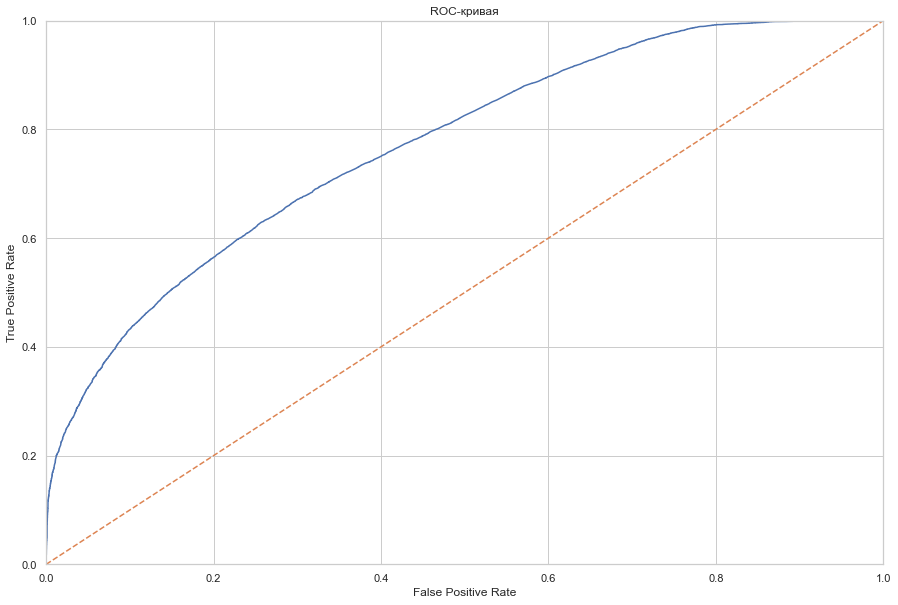

AUC-ROC:  0.7694877951352411


In [48]:
probabilities_valid = CB_model.predict_proba(CB_features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(CB_target_valid, probabilities_one_valid)

plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(CB_target_valid, probabilities_one_valid)

print('AUC-ROC: ', auc_roc)

Забавно, но если возраст авто оставить в категориальных фичах то метрика вырастает с ~0.71 до 0.77

### Random Forest

In [49]:
cat_features = ['party_sobriety', 'cellphone_in_use', 'county_location', 'intersection',
       'weather_1', 'collision_damage', 'primary_collision_factor',
       'pcf_violation_category', 'road_surface', 'road_condition_1',
       'vehicle_type']

num_features = ['vehicle_age']

In [50]:
RF_target = df_for_model['at_fault'].copy()
RF_features = df_for_model.drop(['at_fault'], axis=1).copy()

RF_features_train, RF_features_test, RF_target_train, RF_target_test = train_test_split(RF_features, 
                                                                                         RF_target, 
                                                                                         test_size = .25,
                                                                                         random_state=RANDOM)




scaler.fit(RF_features_train[num_features])
RF_train_num = pd.DataFrame(scaler.transform(RF_features_train[num_features]))
RF_test_num = pd.DataFrame(scaler.transform(RF_features_test[num_features]))
RF_train_num.columns = num_features
RF_test_num.columns = num_features

In [51]:
RF_train_cat = pd.DataFrame(ohe.fit_transform(RF_features_train[cat_features]))
RF_test_cat = pd.DataFrame(ohe.transform(RF_features_test[cat_features]))

In [52]:
RF_features_train = pd.concat([RF_train_num, RF_train_cat], axis=1)
RF_features_test = pd.concat([RF_test_num, RF_test_cat], axis=1)
RF_features_train.head()

,vehicle_age,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
0,-0.928181,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.685528,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.573664,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.282697,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.928181,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
RF_features_train.columns = RF_features_train.columns.astype(str)
RF_features_test.columns = RF_features_test.columns.astype(str)

In [54]:
model = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 45, num = 5)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

RF_rs = RandomizedSearchCV(model, 
                        param_dist, 
                        n_iter = 4, 
                        cv = 4, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=RANDOM,
                       scoring='roc_auc')

RF_rs.fit(RF_features_train, RF_target_train)
RF_rs.predict(RF_features_test)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


array([0, 0, 1, ..., 0, 0, 0])

In [55]:
RF_rs.best_score_

0.6989569096972066

In [ ]:
model = LogisticRegression()

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2','l1', 'none']
max_iter = [500]

param_dist = {
    'solver':solver,
    'penalty':penalty,
    'max_iter':max_iter
        }

lg_rs = RandomizedSearchCV(model, 
                        param_dist, 
                        n_iter = 5, 
                        cv = 4, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=RANDOM,
                        scoring='roc_auc')

lg_rs.fit(RF_features_train, RF_target_train)

In [57]:
lg_rs.best_score_

0.7008951097248294

In [70]:
best_model = {
    'CatBoost' : round(CB_model.get_best_score()['validation']['AUC'], 4),
    'Random Forest' : round(RF_rs.best_score_, 4),
    'LogReg' : round(lg_rs.best_score_, 4)
}
index = ['ROC_AUC']

best_model = pd.DataFrame(best_model, index=index)

In [71]:
best_model

,CatBoost,Random Forest,LogReg
ROC_AUC,0.7695,0.699,0.7009


## Анализ важности факторов ДТП

Лучший результат показала модель CatBoost

Посмотрим на важность фичей по мнению модели

In [60]:
CB_features.columns

Index(['party_sobriety', 'cellphone_in_use', 'county_location', 'intersection',
       'weather_1', 'collision_damage', 'primary_collision_factor',
       'pcf_violation_category', 'road_surface', 'road_condition_1',
       'vehicle_type', 'vehicle_age'],
      dtype='object')

In [61]:
CB_model.feature_importances_

array([25.58814992,  0.39018692,  7.95096031,  1.4813827 ,  2.54791   ,
        3.84996363,  8.17935849, 32.54609684,  2.52665655,  2.95249028,
        5.8893712 ,  6.09747316])

In [62]:
importance = pd.DataFrame({'Признаки': list(CB_features.columns), 'Значимость': list(CB_model.feature_importances_)}).sort_values(by='Значимость', ascending=False)

importance

,Признаки,Значимость
7,pcf_violation_category,32.546097
0,party_sobriety,25.588150
6,primary_collision_factor,8.179358
2,county_location,7.950960
11,vehicle_age,6.097473
10,vehicle_type,5.889371
5,collision_damage,3.849964
9,road_condition_1,2.952490
4,weather_1,2.547910
8,road_surface,2.526657


**Вывод**

Самые важные значения:
- Категория нарушения
- Трезвость водителя
- Основной фактор аварии
Плюс локация аварии и возраст автомобиля имеют достаточное влияние на решение модели

In [72]:
predictions = CB_model.predict(CB_features_valid)



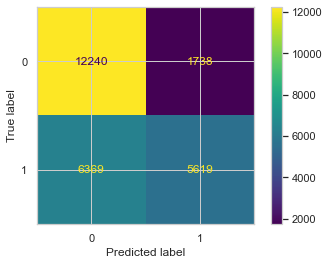

In [73]:
cm = confusion_matrix(CB_target_valid, predictions, labels=CB_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=CB_model.classes_)
disp.plot()
plt.show()

In [74]:
pcf = pd.DataFrame(df.groupby('pcf_violation_category')['at_fault'].sum())
pcf = pcf.reset_index()
pcf

,pcf_violation_category,at_fault
0,automobile right of way,7400
1,brakes,10
2,dui,6367
3,fell asleep,1
4,following too closely,1014
5,hazardous parking,34
6,impeding traffic,33
7,improper passing,540
8,improper turning,8587
9,lights,1


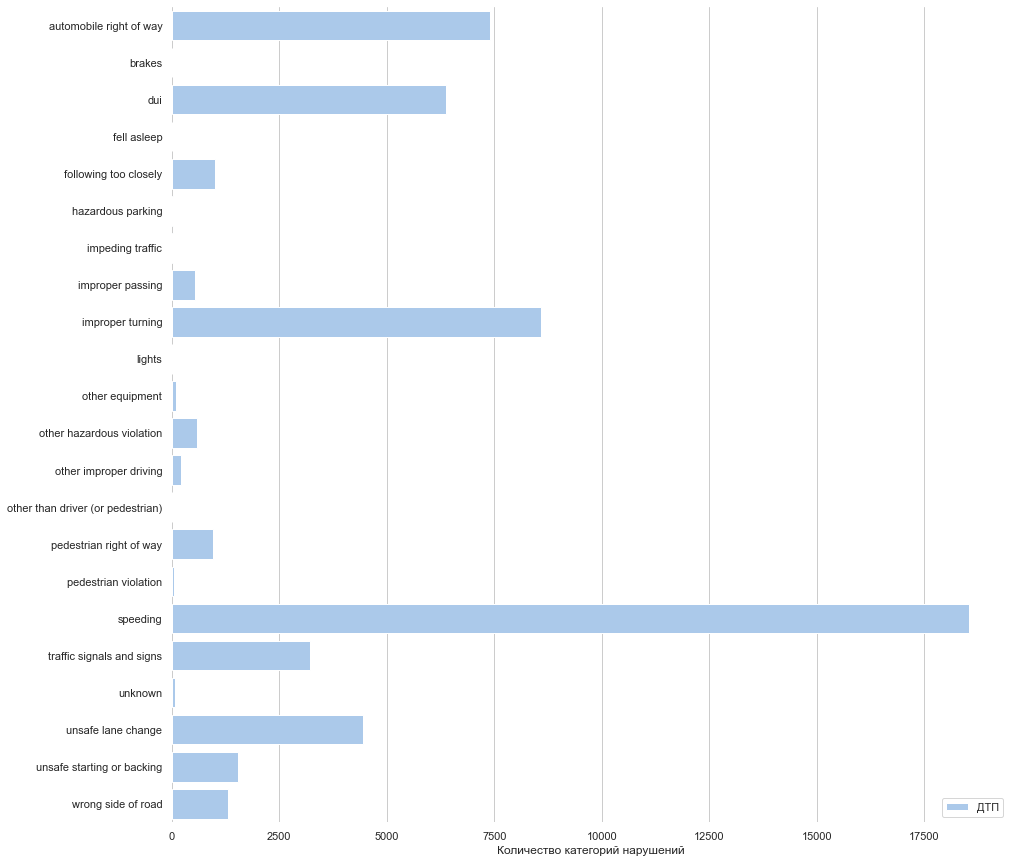

In [75]:
f, ax = plt.subplots(figsize=(15, 15))


sns.set_color_codes("pastel")
sns.barplot(x="at_fault", y="pcf_violation_category", data=pcf,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Количество категорий нарушений")
sns.despine(left=True, bottom=True)

In [76]:
ps = pd.DataFrame(df.groupby('party_sobriety')['at_fault'].sum())
ps = ps.reset_index()
ps

,party_sobriety,at_fault
0,"had been drinking, impairment unknown",450
1,"had been drinking, not under influence",657
2,"had been drinking, under influence",6119
3,had not been drinking,42461
4,impairment unknown,4596
5,not applicable,246


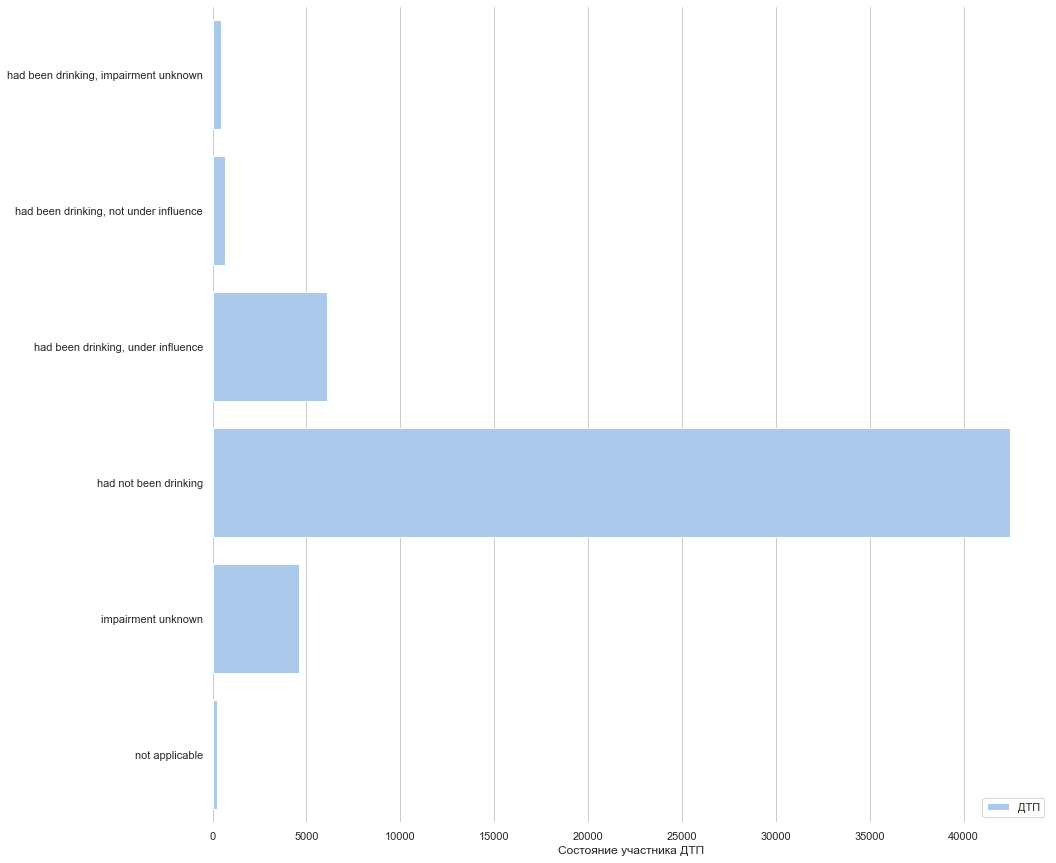

In [77]:
f, ax = plt.subplots(figsize=(15, 15))


sns.set_color_codes("pastel")
sns.barplot(x="at_fault", y="party_sobriety", data=ps,
            label="ДТП", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Состояние участника ДТП")
sns.despine(left=True, bottom=True)

## Выводы

CatBoost оказался самым точным в нашем соревновании!

Видим, что основная причина аварий - это превышение скорости, но при этом НЕ в состоянии алкогольного опьянения) Что странно) обычно одно является следствием другого.

Способ борьбы со скоростью уже изобретен) Камеры и высокие штрафы. Уверен, что статистика в 2022 году будет совершенно другая) В 2012 году камер не было (или были единицы). 

Варианты решения:

- Включить звуковое оповещение о превышении скорости
- Включить физическое ограничение скорости на автомобиле в зависимости от типа дороги и разрешенной скорости на ней
- Внедрить систему наказаний/штрафования водителей каршеринга вплоть до блокировки аккаунта